Hunter Bennett | Glass Lab | Brain Aging Project | 12 Feb 2021  

In [1]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 200
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat
from homer_preprocessing import read_annotated_peaks

# Set working directory

In [2]:
dataDirectory = '/data/mm10/Brain_MPSIIIA/ATAC/Microglia/'
workingDirectory = '/home/h1bennet/brain_aging/results/00_Microglia_ATAC/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)


In [4]:
!ls /data/mm10/Brain_MPSIIIA/ATAC/Microglia/

00_mouse_Bl6_WT_F_4months_Microglia_ATAC_1_JOS_AGGCAGAA
00_mouse_Bl6_WT_F_4months_Microglia_ATAC_2_JOS_GGACTCCT
00_mouse_Bl6_WT_M_14wks_Microglia_ATAC_1_JOS_GAGGGGTT
00_mouse_Sall1WTEnhancer_M_Microglia_ATAC_rep3_BF_l20200128_AAGGAACG
00_mouse_Sall1WTEnhancer_M_Microglia_ATAC_rep4_BF_l20200128_CCAACTCG
01_mouse_Bl6_WT_F_25months_Microglia_ATAC_1_JOS_CCGTTTGT
01_mouse_Bl6_WT_M_24months_Microglia_ATAC_1_JOS_TAAGGCGA
01_mouse_Bl6_WT_M_24months_Microglia_ATAC_2_JOS_CTCTCTAC
01_mouse_Bl6_WT_M_25months_Microglia_ATAC_1_AL_CGATATCA
01_mouse_Bl6_WT_M_25months_Microglia_ATAC_1_JOS_TGCTGGGT
01_mouse_Bl6_WT_M_25months_Microglia_ATAC_2_AL_GAAGTCCG
01_mouse_Bl6_WT_M_25months_Microglia_ATAC_3_AL_CATAACCG
01_mouse_Bl6_WT_M_26months_Microglia_ATAC_1_JOS_CGTACTAG
01_mouse_Bl6_WT_M_26months_Microglia_ATAC_2_JOS_TAAGGCGA
Microglia_ATAC_Control_6wks_110_JoS_16_06_28_S107_L007_R1_001
Microglia-ATAC-Controliso-6wks-111-JoS-16-06-28
Microglia_ATAC_Control_P42_159_JoS_16_07_12_S98_L007_R1_001
Microglia_ATAC_C

# We will start by using O'young's script to get the IDR peaks for each condition
____
These are rather annoying to make in my opinion but for the sake of consistancy with Ty we will use these going forward. Their structure is as follows:
* Column 1: Group ID
* Column 2: Color for analysis
* Column 3: absolute path to files on epiglass for each sample in group, separated by semicolon
* Column 4: corresponding short name for each sample in group, separated by semicolon

Colors
* 4months: '#6baed6'
* 25months: '#3182bd'

The output of peakIDR.R includes many things, the main thing we use are the final .idr peak files for each group


In [8]:
mg_4month_paths = list(np.sort(glob.glob(dataDirectory+'/00_*')))
mg_25month_paths = list(np.sort(glob.glob(dataDirectory+'/01_*25month*')))

In [10]:
mg_4month_paths

['/data/mm10/Brain_MPSIIIA/ATAC/Microglia/00_mouse_Bl6_WT_F_4months_Microglia_ATAC_1_JOS_AGGCAGAA',
 '/data/mm10/Brain_MPSIIIA/ATAC/Microglia/00_mouse_Bl6_WT_F_4months_Microglia_ATAC_2_JOS_GGACTCCT',
 '/data/mm10/Brain_MPSIIIA/ATAC/Microglia/00_mouse_Bl6_WT_M_14wks_Microglia_ATAC_1_JOS_GAGGGGTT',
 '/data/mm10/Brain_MPSIIIA/ATAC/Microglia/00_mouse_Sall1WTEnhancer_M_Microglia_ATAC_rep3_BF_l20200128_AAGGAACG',
 '/data/mm10/Brain_MPSIIIA/ATAC/Microglia/00_mouse_Sall1WTEnhancer_M_Microglia_ATAC_rep4_BF_l20200128_CCAACTCG']

In [72]:
ids = ['mg_4month',
       'mg_25month']
colors = ['#6baed6',
          '#3182bd']
paths = [';'.join(mg_4month_paths),
         ';'.join(mg_25month_paths)]
short_ids = [';'.join(['mg_4month_rep1', 'mg_4month_rep2', 'rep14wks1', 'mg_4month_BF1', 'mg_4month_BF2']),
             ';'.join(['mg_25month_repF1', 'mg_25month_rep1', 'mg_25month_JS1', 'mg_25month_rep2', 'mg_25month_rep3'])]

In [73]:
pd.DataFrame([ids,colors,paths,short_ids]).T.to_csv('./sampleDef.txt',
                                                    sep='\t',
                                                    header=False,
                                                    index=False)

In [74]:
pd.DataFrame([ids,colors,paths,short_ids]).T

,0,1,2,3
0,c57bl6j_kupffer_amln_30weeks,#4daf4a,/home/h1bennet/strains/data/ATAC/AMLN_30week/0...,c57bl6j_kupffer_amln_30weeks_LN203D;c57bl6j_ku...
1,balbcj_kupffer_amln_30weeks,#3773b8,/home/h1bennet/strains/data/ATAC/AMLN_30week/0...,balbcj_kupffer_amln_30weeks_Balb3C;balbcj_kupf...
2,aj_kupffer_amln_30weeks,#e41a1c,/home/h1bennet/strains/data/ATAC/AMLN_30week/0...,aj_kupffer_amln_30weeks_AJ3A;aj_kupffer_amln_3...


Run: peakIDR.R sampleDef.txt in the r-ouyangPipe environment, then continue

In [12]:
# %%bash
# # if directories don't exist, create them
# if [ ! -d ./atac_peak_files/ ]; then mkdir ./atac_peak_files; fi
# # move IDR peaks into atac_peak_folder
# mv *microglia*.idr ./atac_peak_files

### Merge peaks

In [76]:
if not os.path.isdir('./merged_peaks/'):
    os.mkdir('./merged_peaks/')

In [77]:
with open('./mergePeaks_homer.sh', 'w') as f:
    peakfiles = np.sort(glob.glob('./atac_peak_files/*'))
    merge_peaks = ['mergePeaks', '-d', 'given',
                   ' '.join(peakfiles), '>',
                   './merged_peaks/idr_peaks_merged.txt', '\n']
    f.write(' '.join(merge_peaks))    
f.close()

# Annotate peaks

In [79]:
# grab relevant tag directories
tagdirs = np.sort(glob.glob('/gpfs/data01/glasslab/home/h1bennet/strains/data/ATAC/AMLN_30week/*'))

drop_files = ['NaN']

# drop files if necessary
tagdirs = pd.Series(tagdirs)[~pd.Series(tagdirs).str.contains('|'.join(drop_files))].tolist()

Create script to annotate peaks with HOMER - its possible that this is resizing the peaks and thats why downstream we dont have to do anything

In [33]:
with open('./annotatePeaks_homer.sh', 'w') as f:
    annotate_raw = ['annotatePeaks.pl', './merged_peaks/idr_peaks_merged.txt',
                       'mm10', '-size 200', '-raw', '-d \\\n',
                       ' \\\n'.join(tagdirs), '>',
                       './merged_peaks/ann_raw_idr_peaks_merged.txt &\n\n']
    
    annotate_norm = ['annotatePeaks.pl', './merged_peaks/idr_peaks_merged.txt',
                       'mm10', '-size 200', '-norm 1e7', '-d \\\n',
                       ' \\\n'.join(tagdirs), '>',
                       './merged_peaks/ann_norm_idr_peaks_merged.txt &\n']
    
    f.write(' '.join(annotate_raw))    
    f.write(' '.join(annotate_norm))
    
    f.close()

# Summary plots

In [80]:
# make folder for figures
if not os.path.isdir('./figures'):
    os.mkdir('./figures')

### Read in annotation files

In [13]:
# import annotation file
df, mat = read_annotated_peaks('./merged_peaks/ann_norm_idr_peaks_merged.txt')

# shorten columns to make labeling nicer
mat.columns = mat.columns.str.split('/').str[-1]

# quantile normalize data
mat_quant = quantile_normalize_df(mat)

In [14]:
mat.columns

Index(['00_mouse_Bl6_WT_F_4months_Microglia_ATAC_1_JOS_AGGCAGAA',
       '00_mouse_Bl6_WT_F_4months_Microglia_ATAC_2_JOS_GGACTCCT',
       '00_mouse_Bl6_WT_M_14wks_Microglia_ATAC_1_JOS_GAGGGGTT',
       '00_mouse_Sall1WTEnhancer_M_Microglia_ATAC_rep3_BF_l20200128_AAGGAACG',
       '00_mouse_Sall1WTEnhancer_M_Microglia_ATAC_rep4_BF_l20200128_CCAACTCG',
       '01_mouse_Bl6_WT_F_25months_Microglia_ATAC_1_JOS_CCGTTTGT',
       '01_mouse_Bl6_WT_M_25months_Microglia_ATAC_1_AL_CGATATCA',
       '01_mouse_Bl6_WT_M_25months_Microglia_ATAC_1_JOS_TGCTGGGT',
       '01_mouse_Bl6_WT_M_25months_Microglia_ATAC_2_AL_GAAGTCCG',
       '01_mouse_Bl6_WT_M_25months_Microglia_ATAC_3_AL_CATAACCG'],
      dtype='object')

Filter low tag peaks

In [16]:
# use group based mat filter - have to set manually
print(mat.shape[0], 'total peaks')
print('filtering low tag count peaks')
groups=[[0,1,2,3,4], [5, 6,7,8,9]]
peaks = []
for group in groups:
    peaks.extend(mat.loc[mat.iloc[:, group].mean(1) > 8, :].index.tolist())
mat = mat.reindex(list(set(peaks)))
mat = mat.dropna(how='all')
mat_quant = mat_quant.reindex(list(set(peaks)))
mat_quant = mat_quant.dropna(how='all')
print(mat.shape[0], 'total peaks')

114610 total peaks
filtering low tag count peaks
102463 total peaks


### Mean variance plot

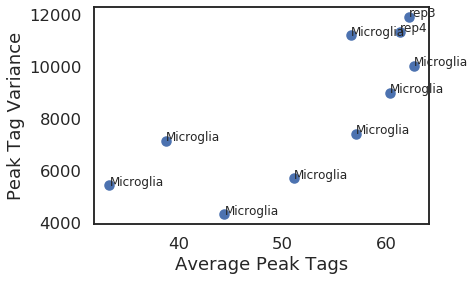

In [20]:
ax = plt.scatter(mat.mean(), mat.var())
plt.xlabel('Average Peak Tags')
plt.ylabel('Peak Tag Variance')
label_point(mat.mean(),
            mat.var(),
            mat_quant.columns.str.split('_').str[6],
            plt.gca())

plt.savefig('./figures/mean_variance_plot.png',
            bbox_inches='tight')

### Try with quantile normalized data

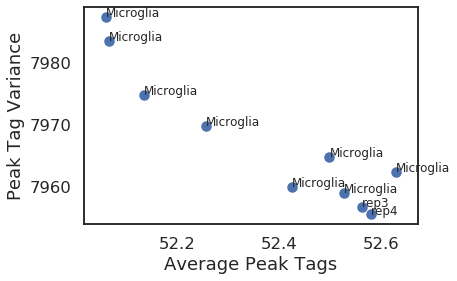

In [21]:
ax = plt.scatter(mat_quant.mean(), mat_quant.var())
plt.xlabel('Average Peak Tags')
plt.ylabel('Peak Tag Variance')
label_point(mat_quant.mean(),
            mat_quant.var(),
            mat_quant.columns.str.split('_').str[6],
            plt.gca())

plt.savefig('./figures/mean_variance_plot_quantnorm.png',
            bbox_inches='tight')

### Scatter plot

In [22]:
# g = sns.PairGrid(np.log2(mat+1), height=10)
# g.map(plt.scatter);
# plt.savefig('./figures/atac_corr_scatter.png', bbox_inches='tight')

In [23]:
# g = sns.PairGrid(np.log2(mat_quant+1), height=10)
# g.map(plt.scatter);
# plt.savefig('./figures/atac_corr_scatter_quantnorm.png', bbox_inches='tight')

### Correlation heatmap

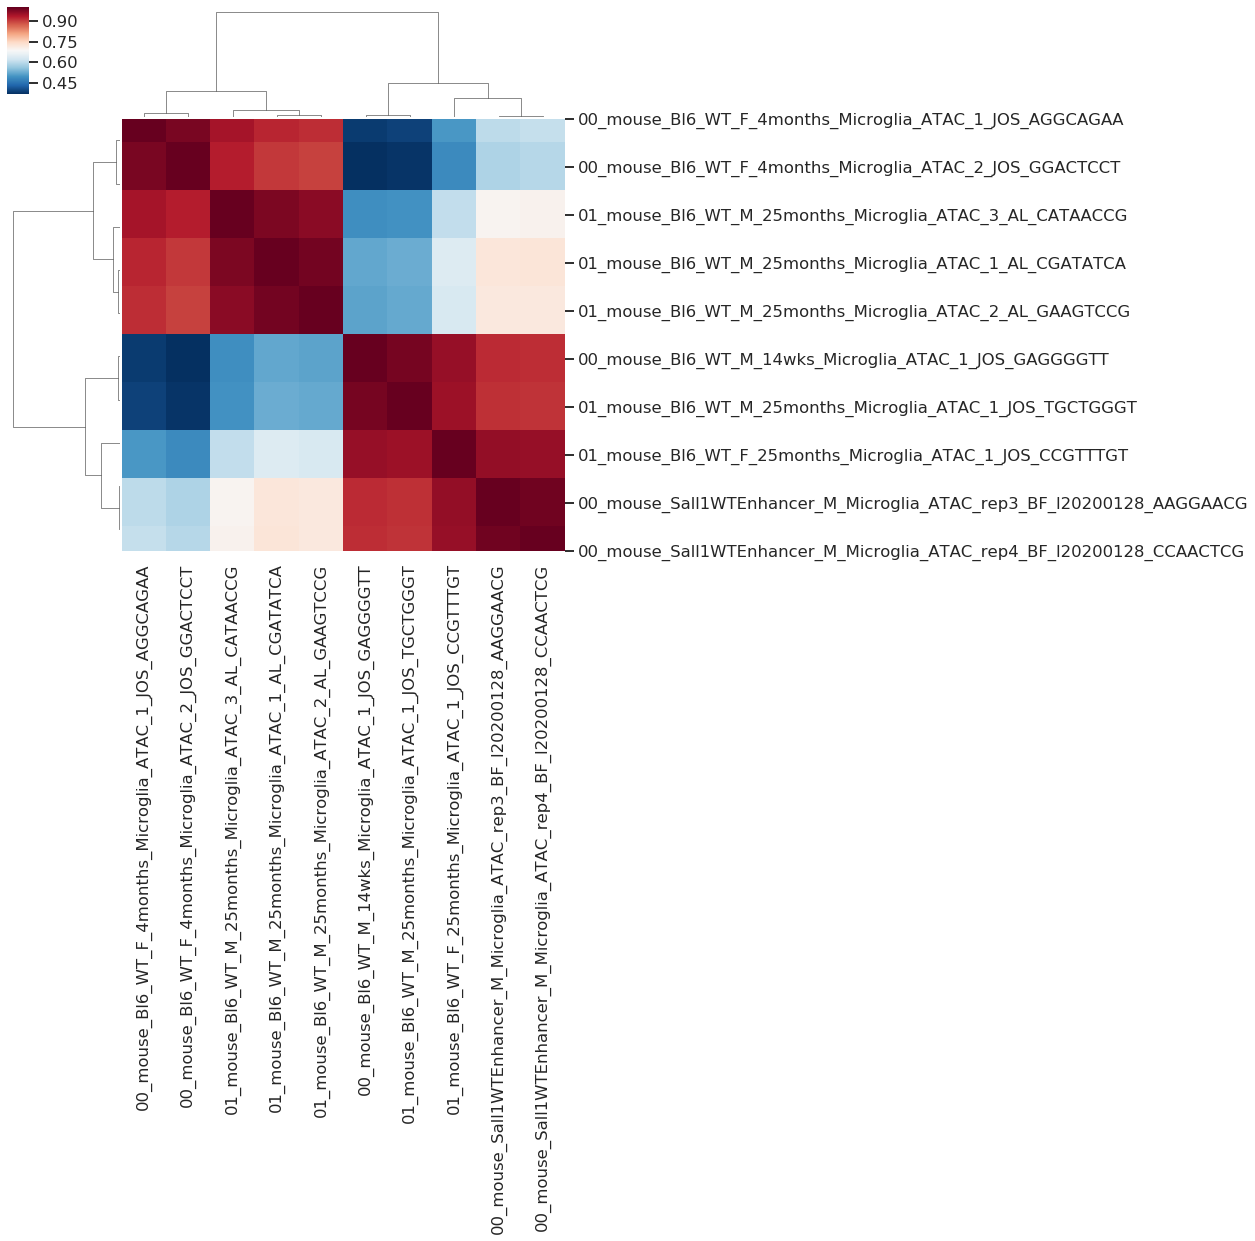

In [24]:
cm = sns.clustermap(mat.corr(), cmap='RdBu_r')
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);
plt.savefig('./figures/atac_correlation_heatmap.png', bbox_inches='tight')

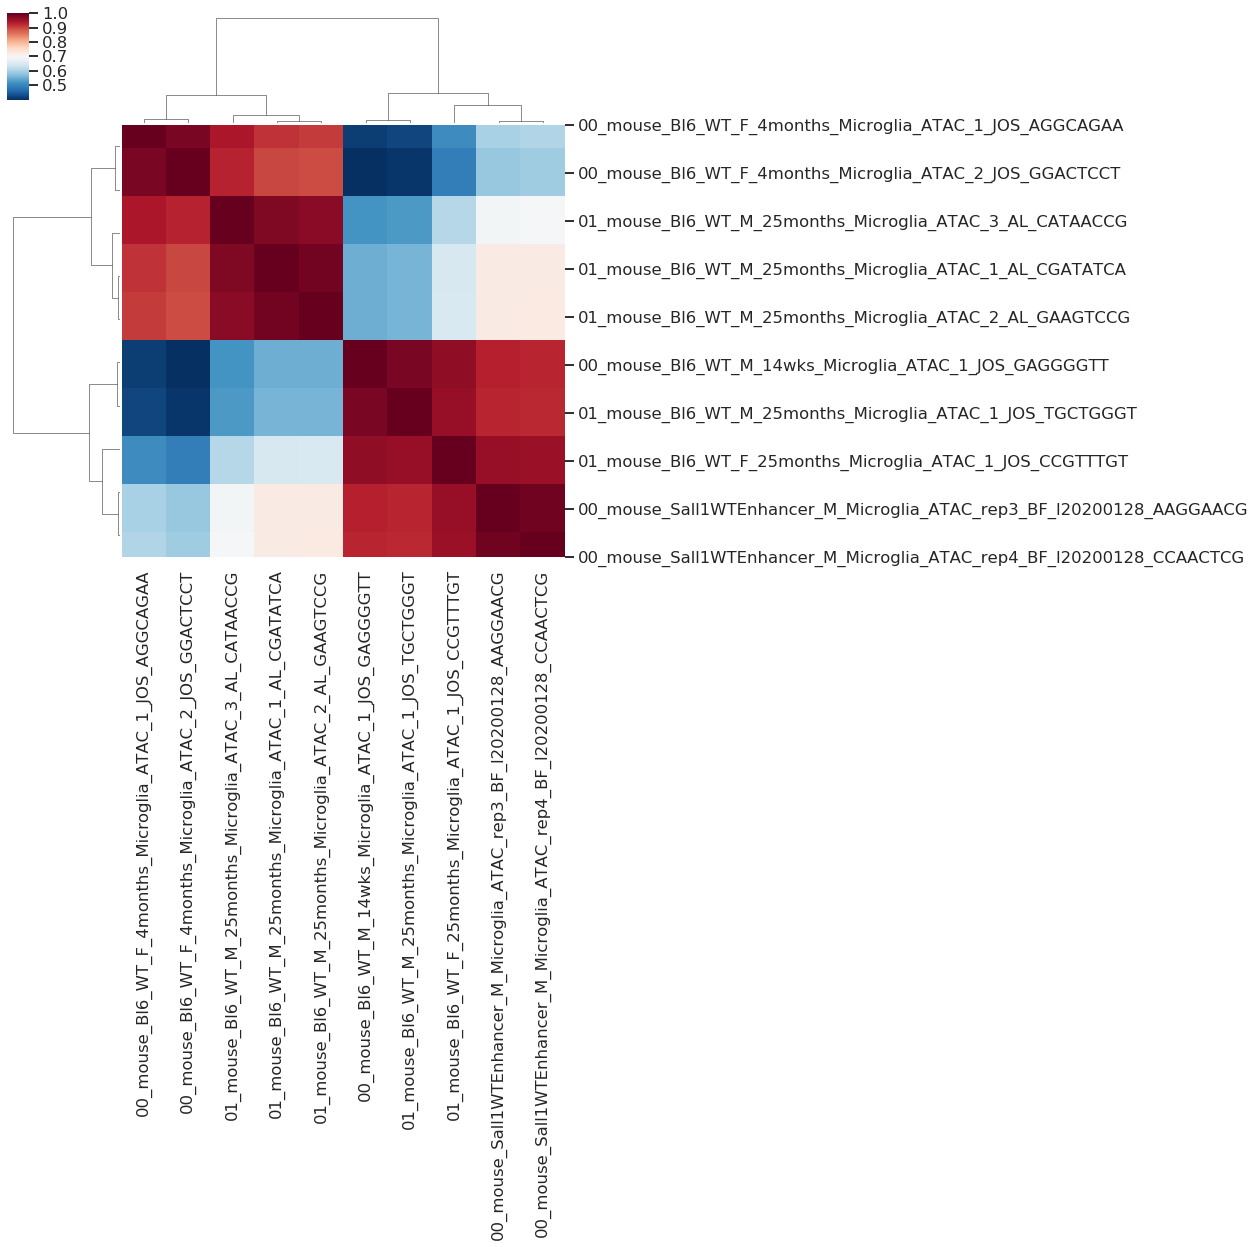

In [28]:
cm = sns.clustermap(mat_quant.corr(), cmap='RdBu_r')
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);
plt.savefig('./figures/atac_correlation_heatmap_quantnorm.png', bbox_inches='tight')

In [29]:
mat_distal = mat.reindex(df.loc[np.abs(df['Distance to TSS']) >= 3000.0].index.tolist())
mat_distal.dropna(inplace=True)

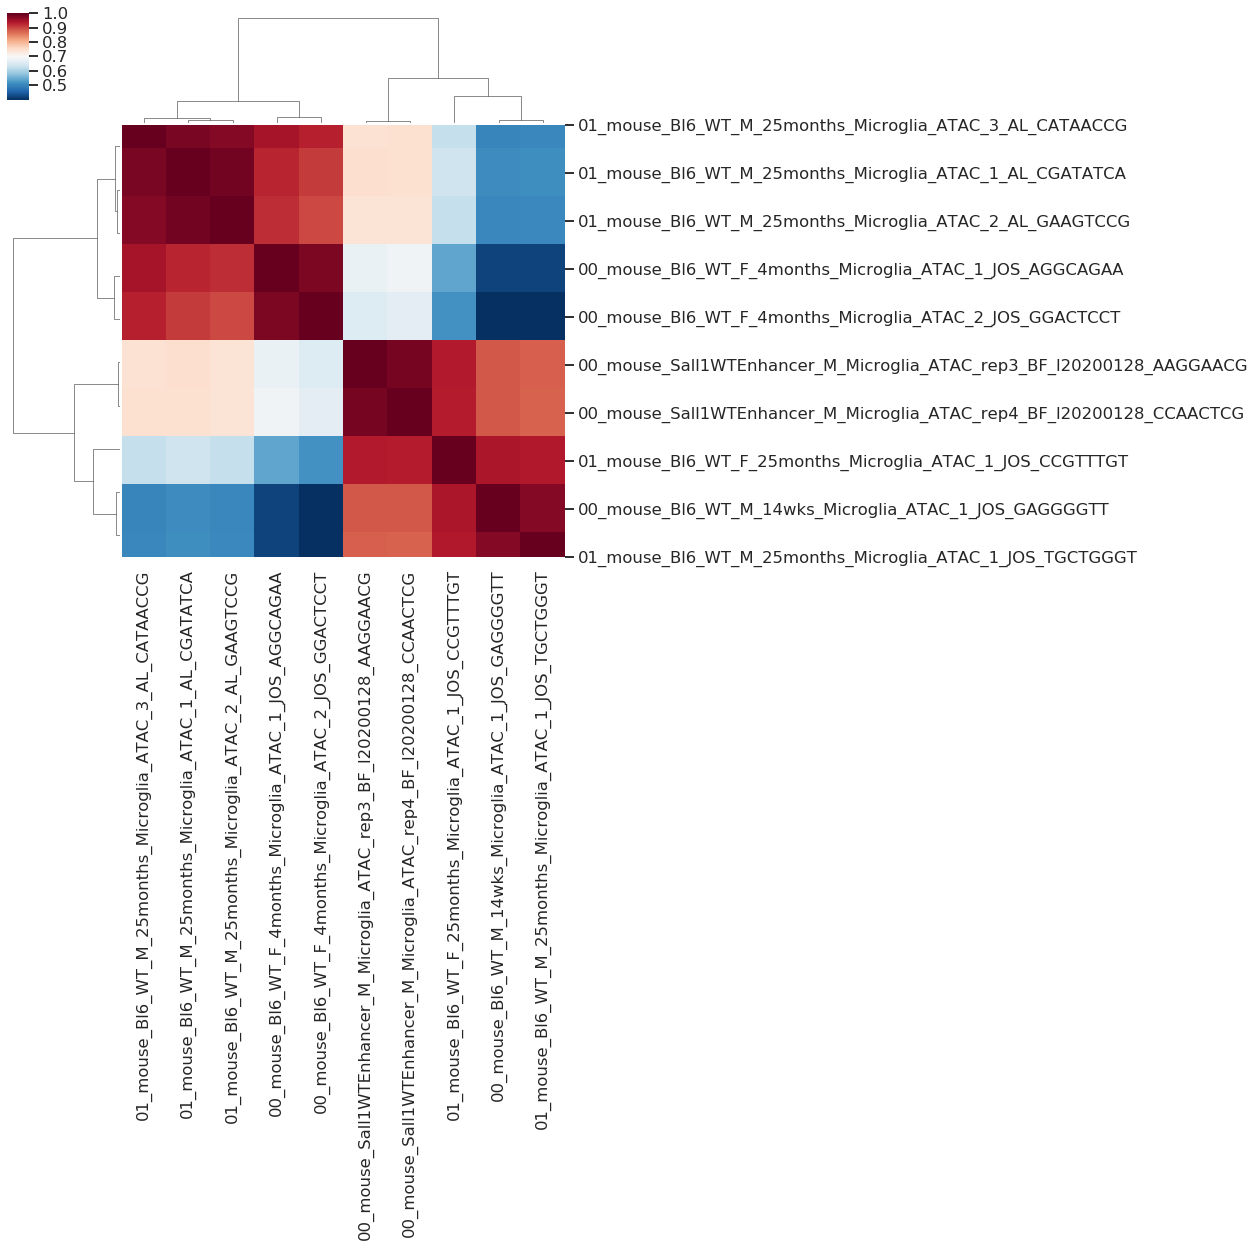

In [30]:
cm = sns.clustermap(mat_distal.corr(), cmap='RdBu_r')
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);
plt.savefig('./figures/atac_correlation_distal_heatmap.png', bbox_inches='tight')

# Principal Component Analysis

Create sample ID data frame for ease of plotting

In [35]:
# this part must be done manually - use the sample ID fields to pick out
# identifiers for each sample.
samples = pd.Series(mat.columns.str.split('/').str[-1])
group = samples.str.split('_').str[0]
strain = samples.str.split('_').str[1]
cell = samples.str.split('_').str[2]
treatment = samples.str.split('_').str[4]
treatment_time = samples.str.split('_').str[5]
mouseid = samples.str.split('_').str[-3]
sampledate = samples.str.split('_').str[-1]
                                        
samplesDF = pd.DataFrame([pd.Series(samples),
                          pd.Series(group),
                          pd.Series(strain),
                          pd.Series(cell),
                          pd.Series(treatment),
                          pd.Series(treatment_time),
                          pd.Series(mouseid),
                          pd.Series(sampledate)],
                         index=['mouse', 'group', 'strain', 'celltype',
                                'treatment', 'treatment_time', 'mouse_id',
                                'sample_date']).T

In [38]:
samplesDF

,mouse,group,strain,celltype,treatment,treatment_time,mouse_id,sample_date
0,00_mouse_Bl6_WT_F_4months_Microglia_ATAC_1_JOS...,00,mouse,Bl6,F,4months,1,AGGCAGAA
1,00_mouse_Bl6_WT_F_4months_Microglia_ATAC_2_JOS...,00,mouse,Bl6,F,4months,2,GGACTCCT
2,00_mouse_Bl6_WT_M_14wks_Microglia_ATAC_1_JOS_G...,00,mouse,Bl6,M,14wks,1,GAGGGGTT
3,00_mouse_Sall1WTEnhancer_M_Microglia_ATAC_rep3...,00,mouse,Sall1WTEnhancer,Microglia,ATAC,BF,AAGGAACG
4,00_mouse_Sall1WTEnhancer_M_Microglia_ATAC_rep4...,00,mouse,Sall1WTEnhancer,Microglia,ATAC,BF,CCAACTCG
5,01_mouse_Bl6_WT_F_25months_Microglia_ATAC_1_JO...,01,mouse,Bl6,F,25months,1,CCGTTTGT
6,01_mouse_Bl6_WT_M_25months_Microglia_ATAC_1_AL...,01,mouse,Bl6,M,25months,1,CGATATCA
7,01_mouse_Bl6_WT_M_25months_Microglia_ATAC_1_JO...,01,mouse,Bl6,M,25months,1,TGCTGGGT
8,01_mouse_Bl6_WT_M_25months_Microglia_ATAC_2_AL...,01,mouse,Bl6,M,25months,2,GAAGTCCG
9,01_mouse_Bl6_WT_M_25months_Microglia_ATAC_3_AL...,01,mouse,Bl6,M,25months,3,CATAACCG


### Look at PCA plots for all the samples

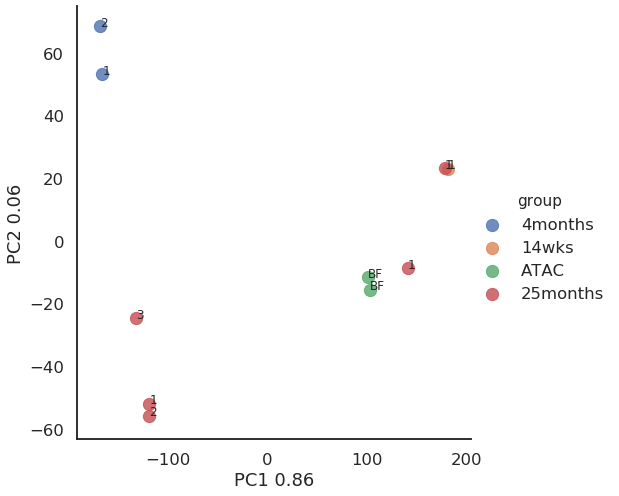

In [39]:
pca, exp_var, pcs = pca_rpkm_mat(rpkm=mat,
                                 group_labels=samplesDF.treatment_time,
                                 plot_size=7,
                                 n_pca=3)

label_point(pca.PC1,
            pca.PC2,
            samplesDF.mouse_id,
            plt.gca())

plt.savefig('./figures/atac_pca1_pca2.png', bbox_inches='tight')

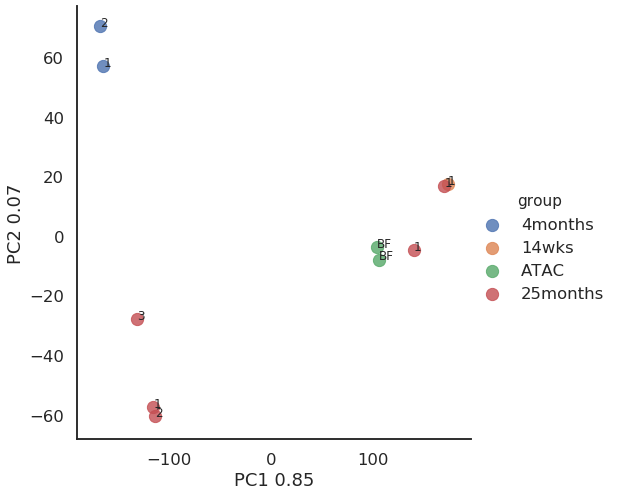

In [40]:
pca, exp_var, pcs = pca_rpkm_mat(rpkm=mat_quant,
                                 group_labels=samplesDF.treatment_time,
                                 plot_size=7,
                                 n_pca=3)
label_point(pca.PC1,
            pca.PC2,
            samplesDF.mouse_id,
            plt.gca())

plt.savefig('./figures/atac_pca1_pca2_quantnorm.png', bbox_inches='tight')

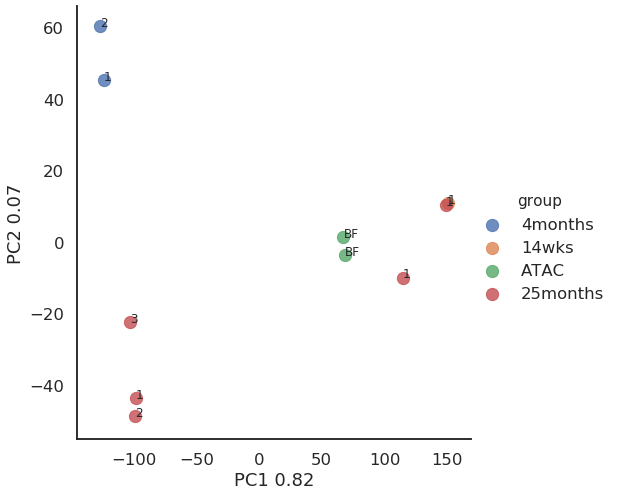

In [41]:
pca, exp_var, pcs = pca_rpkm_mat(rpkm=mat_distal,
                                 group_labels=samplesDF.treatment_time,
                                 plot_size=7,
                                 n_pca=3)

label_point(pca.PC1,
            pca.PC2,
            samplesDF.mouse_id,
            plt.gca())

plt.savefig('./figures/atac_distal_pca1_pca2.png', bbox_inches='tight')

# Optional: Repeat analysis with outliers dropped
____ 


In [61]:
mat.columns

Index(['00_mouse_Bl6_WT_F_4months_Microglia_ATAC_1_JOS_AGGCAGAA',
       '00_mouse_Bl6_WT_F_4months_Microglia_ATAC_2_JOS_GGACTCCT',
       '00_mouse_Bl6_WT_M_14wks_Microglia_ATAC_1_JOS_GAGGGGTT',
       '00_mouse_Sall1WTEnhancer_M_Microglia_ATAC_rep3_BF_l20200128_AAGGAACG',
       '00_mouse_Sall1WTEnhancer_M_Microglia_ATAC_rep4_BF_l20200128_CCAACTCG',
       '01_mouse_Bl6_WT_F_25months_Microglia_ATAC_1_JOS_CCGTTTGT',
       '01_mouse_Bl6_WT_M_25months_Microglia_ATAC_1_AL_CGATATCA',
       '01_mouse_Bl6_WT_M_25months_Microglia_ATAC_1_JOS_TGCTGGGT',
       '01_mouse_Bl6_WT_M_25months_Microglia_ATAC_2_AL_GAAGTCCG',
       '01_mouse_Bl6_WT_M_25months_Microglia_ATAC_3_AL_CATAACCG'],
      dtype='object')

In [63]:
df.columns

Index(['Chr', 'Start', 'End', 'Strand', 'Peak Score',
       'Focus Ratio/Region Size', 'Annotation', 'Detailed Annotation',
       'Distance to TSS', 'Nearest PromoterID', 'Entrez ID', 'Nearest Unigene',
       'Nearest Refseq', 'Nearest Ensembl', 'Gene Name', 'Gene Alias',
       'Gene Description', 'Gene Type',
       '/gpfs/data01/glasslab/data/mm10/Brain_MPSIIIA/ATAC/Microglia/00_mouse_Bl6_WT_F_4months_Microglia_ATAC_1_JOS_AGGCAGAA',
       '/gpfs/data01/glasslab/data/mm10/Brain_MPSIIIA/ATAC/Microglia/00_mouse_Bl6_WT_F_4months_Microglia_ATAC_2_JOS_GGACTCCT',
       '/gpfs/data01/glasslab/data/mm10/Brain_MPSIIIA/ATAC/Microglia/00_mouse_Bl6_WT_M_14wks_Microglia_ATAC_1_JOS_GAGGGGTT',
       '/gpfs/data01/glasslab/data/mm10/Brain_MPSIIIA/ATAC/Microglia/00_mouse_Sall1WTEnhancer_M_Microglia_ATAC_rep3_BF_l20200128_AAGGAACG',
       '/gpfs/data01/glasslab/data/mm10/Brain_MPSIIIA/ATAC/Microglia/00_mouse_Sall1WTEnhancer_M_Microglia_ATAC_rep4_BF_l20200128_CCAACTCG',
       '/gpfs/data01/glas

In [87]:
# import annotation file
df, mat = read_annotated_peaks('./merged_peaks/ann_norm_idr_peaks_merged.txt')

# try with dropped sample
drop_files = ['/gpfs/data01/glasslab/data/mm10/Brain_MPSIIIA/ATAC/Microglia/00_mouse_Bl6_WT_M_14wks_Microglia_ATAC_1_JOS_GAGGGGTT',
             '/gpfs/data01/glasslab/data/mm10/Brain_MPSIIIA/ATAC/Microglia/01_mouse_Bl6_WT_M_25months_Microglia_ATAC_1_JOS_TGCTGGGT']

df = df.drop(drop_files, axis=1)
mat = mat.drop(drop_files, axis=1)

# shorten columns to make labeling nicer
mat.columns = mat.columns.str.split('/').str[-1]

# quantile normalize data
mat_quant = quantile_normalize_df(mat)

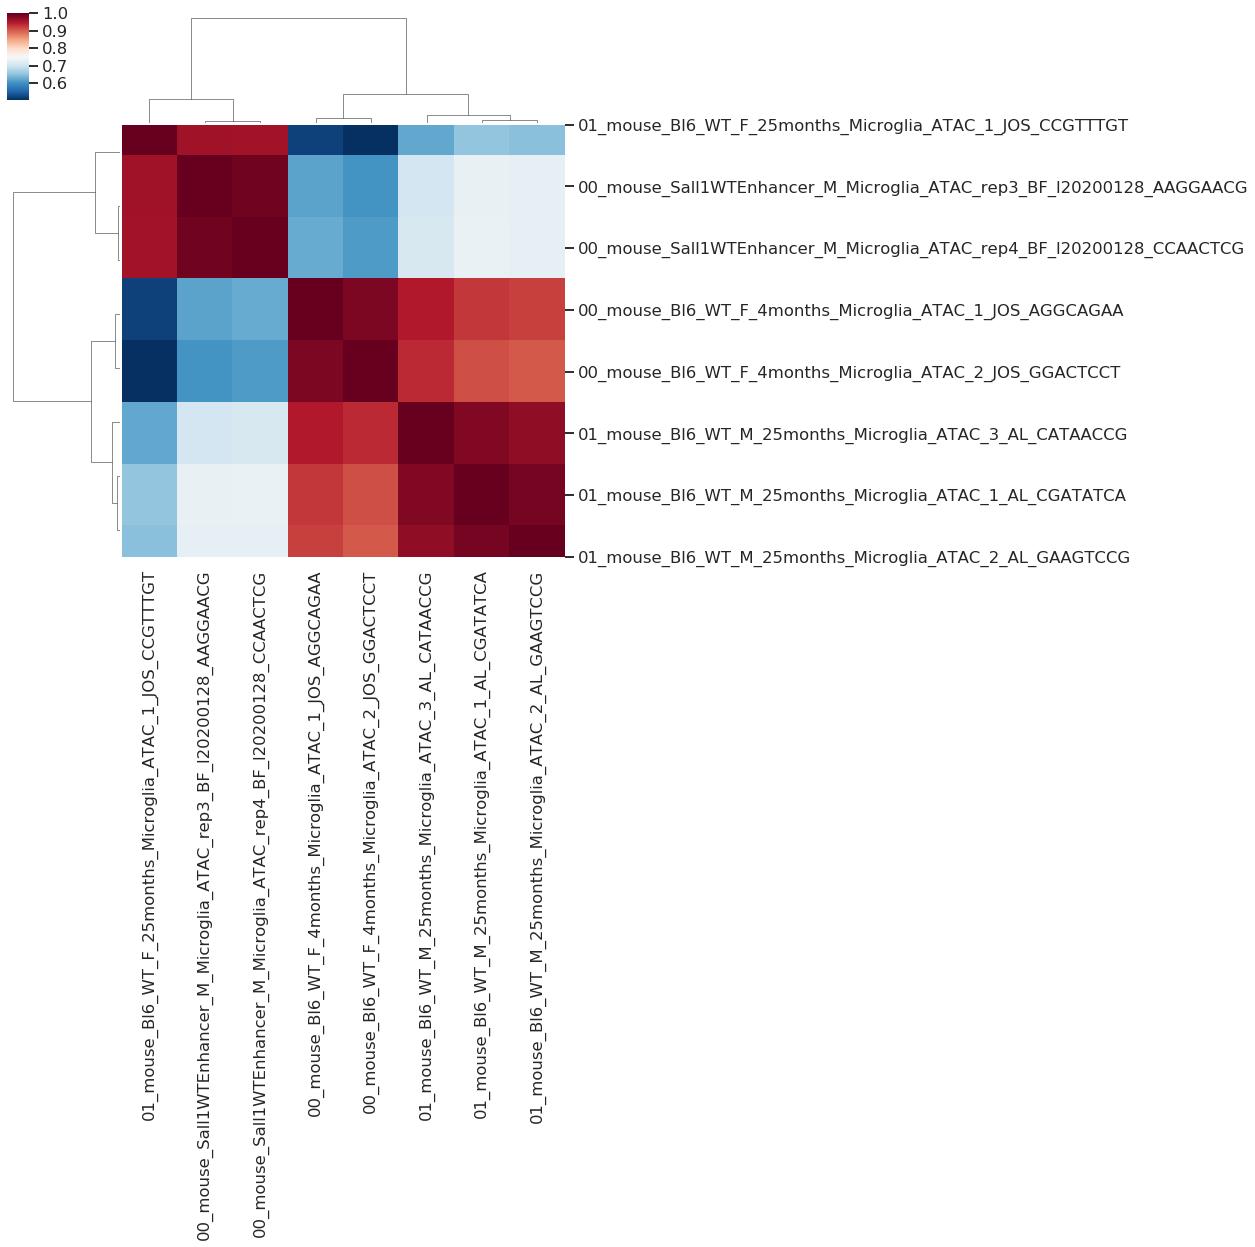

In [67]:
cm = sns.clustermap(mat.corr(), cmap='RdBu_r')
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);
plt.savefig('./figures/atac_correlation_heatmap_outliers_dropped.png', bbox_inches='tight')

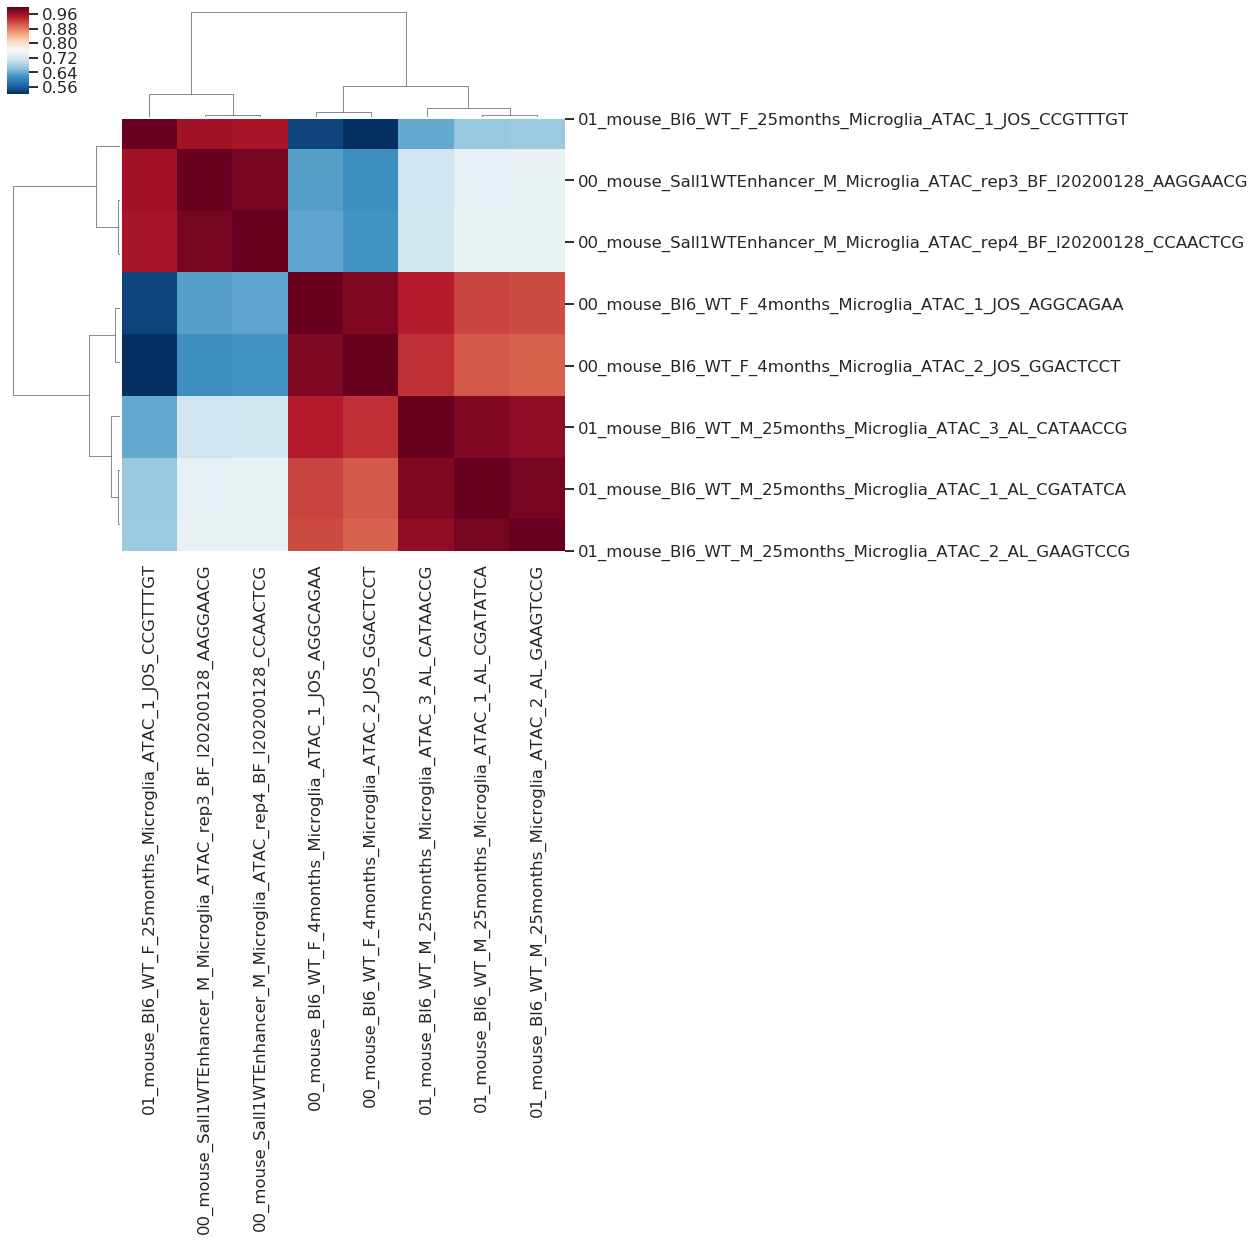

In [68]:
cm = sns.clustermap(mat_quant.corr(), cmap='RdBu_r')
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);
plt.savefig('./figures/atac_correlation_heatmap_quantnorm_outliers_dropped.png', bbox_inches='tight')

In [69]:
mat_distal = mat.reindex(df.loc[np.abs(df['Distance to TSS']) >= 3000.0].index.tolist())
mat_distal.dropna(inplace=True)

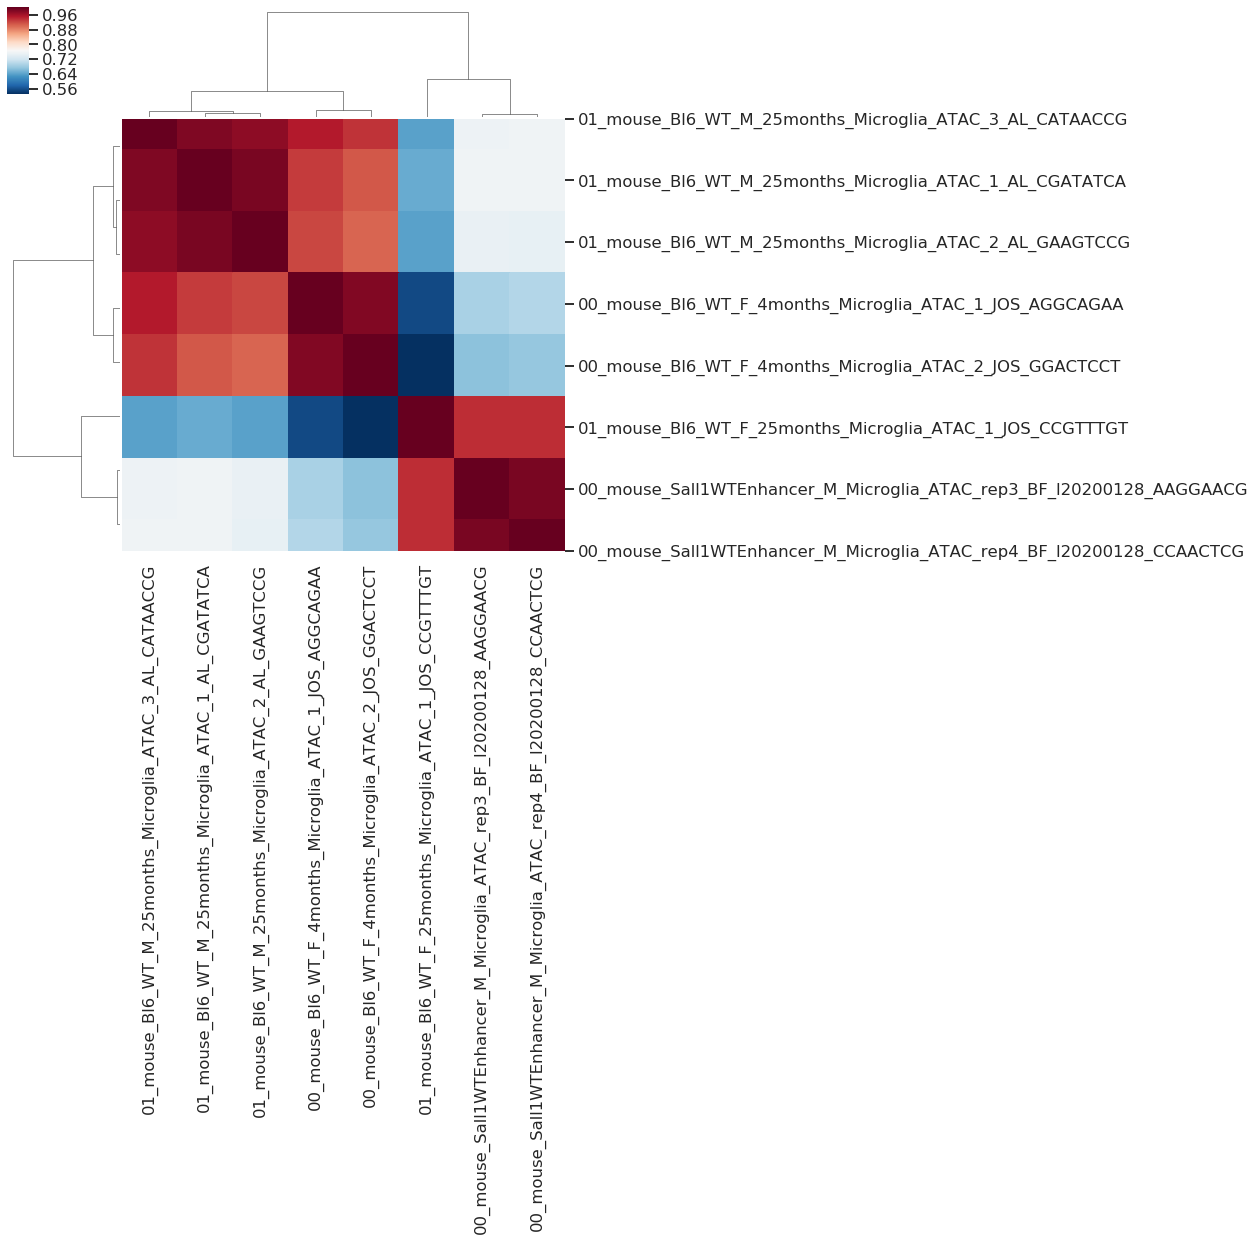

In [70]:
cm = sns.clustermap(mat_distal.corr(), cmap='RdBu_r')
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);
plt.savefig('./figures/atac_correlation_distal_heatmap_outliers_dropped.png', bbox_inches='tight')

# Principal Component Analysis

Create sample ID data frame for ease of plotting

In [71]:
# this part must be done manually - use the sample ID fields to pick out
# identifiers for each sample.
samples = pd.Series(mat.columns.str.split('/').str[-1])
group = samples.str.split('_').str[0]
strain = samples.str.split('_').str[1]
cell = samples.str.split('_').str[2]
treatment = samples.str.split('_').str[4]
treatment_time = samples.str.split('_').str[5]
mouseid = samples.str.split('_').str[-3]
sampledate = samples.str.split('_').str[-1]
                                        
samplesDF = pd.DataFrame([pd.Series(samples),
                          pd.Series(group),
                          pd.Series(strain),
                          pd.Series(cell),
                          pd.Series(treatment),
                          pd.Series(treatment_time),
                          pd.Series(mouseid),
                          pd.Series(sampledate)],
                         index=['mouse', 'group', 'strain', 'celltype',
                                'treatment', 'treatment_time', 'mouse_id',
                                'sample_date']).T

### PCA - outliers removed

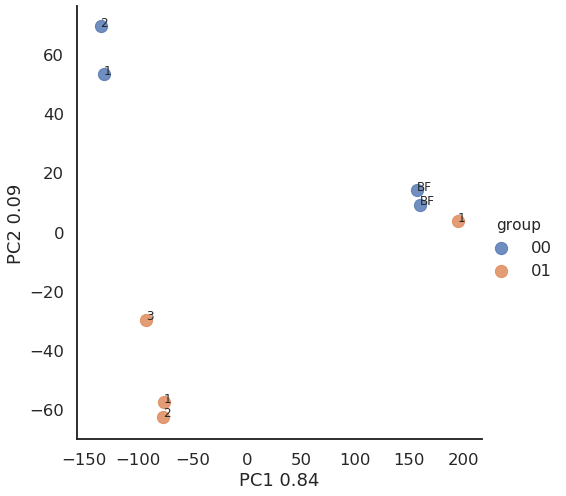

In [72]:
pca, exp_var, pcs = pca_rpkm_mat(rpkm=mat,
                                 group_labels=samplesDF.group,
                                 plot_size=7,
                                 n_pca=3)

label_point(pca.PC1,
            pca.PC2,
            samplesDF.mouse_id,
            plt.gca())

plt.savefig('./figures/atac_pca1_pca2_outliers_dropped.png', bbox_inches='tight')

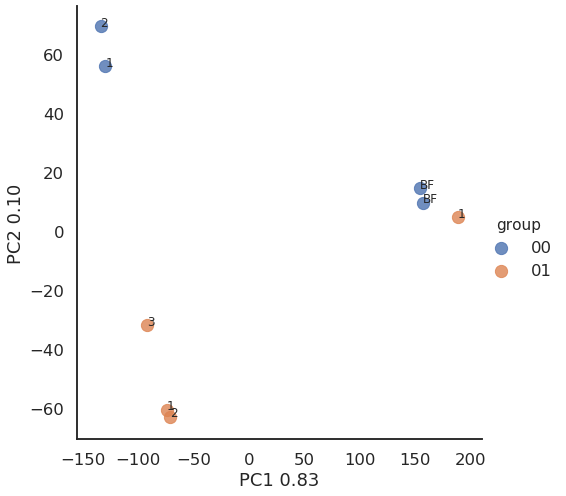

In [73]:
pca, exp_var, pcs = pca_rpkm_mat(rpkm=mat_quant,
                                 group_labels=samplesDF.group,
                                 plot_size=7,
                                 n_pca=3)
label_point(pca.PC1,
            pca.PC2,
            samplesDF.mouse_id,
            plt.gca())

plt.savefig('./figures/atac_pca1_pca2_quantnorm_outliers_dropped.png', bbox_inches='tight')

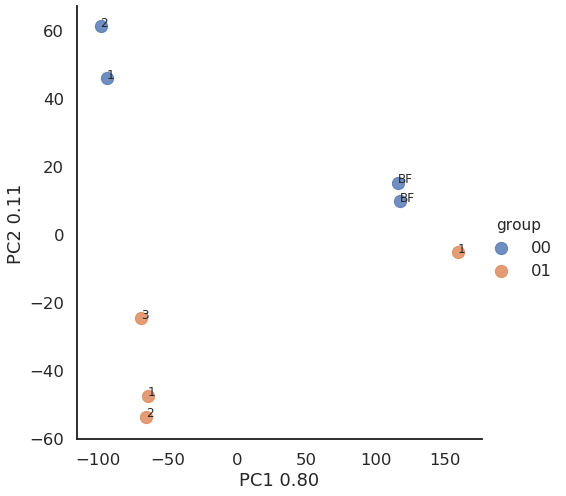

In [74]:
pca, exp_var, pcs = pca_rpkm_mat(rpkm=mat_distal,
                                 group_labels=samplesDF.group,
                                 plot_size=7,
                                 n_pca=3)

label_point(pca.PC1,
            pca.PC2,
            samplesDF.mouse_id,
            plt.gca())

plt.savefig('./figures/atac_distal_pca1_pca2_outliers_dropped.png', bbox_inches='tight')

# Make Venn Diagram of Poised Enhancers

In [75]:
from matplotlib_venn import venn2

In [76]:
groups = ['Microglia_4months', 'Microglia_25months']
columns = [[0,1,2,3],
           [4,5,6,7]]

avg_tags = {}

for group, col in zip(groups, columns):
    avg_tags[group] = mat.iloc[:, col].mean(1)
    
avg_tags_df = pd.DataFrame(avg_tags)

In [77]:
thresh=8

peak_dict = {}
for col in avg_tags_df.columns:
    peak_dict[col] = avg_tags_df.index[avg_tags_df[col]>thresh].tolist()

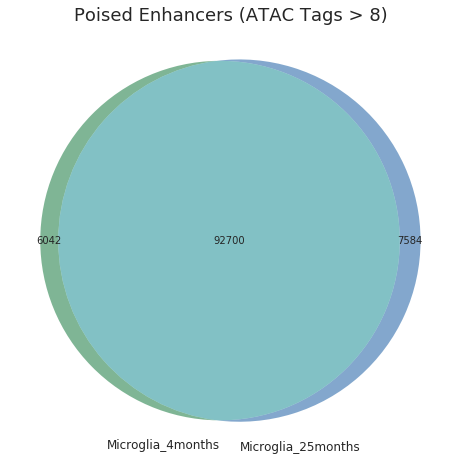

In [78]:
fig, ax = plt.subplots(figsize=(8,8))

# venn3 accepts a list with the following order
# (100, 010, 110, 001, 101, 011, 111)
# group1, group2, group1+2, group3, group1+3, group2+3, group3
venn2(subsets=[set(peak_dict['Microglia_4months']),
               set(peak_dict['Microglia_25months'])],
      set_colors=('#006d2c', '#08519c'),
      set_labels=('Microglia_4months', 'Microglia_25months'),
      alpha=0.5,
      ax=ax)
ax.set_title('Poised Enhancers (ATAC Tags > %d)' % thresh);

plt.savefig('./figures/venn3_poised_ATAC_peaks.png', bbox_inches='tight')

# Write 'poised' enhancers out for analysis with HOMER
___
Should use the same threshold as venn diagram above

In [79]:
if not os.path.isdir('./poised_enhancers/'):
    os.mkdir('./poised_enhancers/')

Select distal peaks

In [80]:
df_distal = df.loc[np.abs(df['Distance to TSS']) > 3*10**3, :]

if np.NaN get introduced into the matrix then it converts 'int' type columns to 'float' type columns, this is not ideal and interferes with downstream peak analysis so we create a dict to change the start and end columns back to integers just in case

In [81]:
convert_dict = {'Start': int,
                'End': int}

In [82]:
for col in avg_tags_df.columns:
    tmp = df.reindex(avg_tags_df.index[avg_tags_df[col]>thresh].tolist())
    tmp = tmp.dropna(how='all').iloc[:, :5]
    tmp = tmp.astype(convert_dict)
    tmp.to_csv('./poised_enhancers/'+col+'_poised_enhancer_peaks.txt', sep='\t')
    
    tmp = df_distal.reindex(avg_tags_df.index[avg_tags_df[col]>thresh].tolist())
    tmp = tmp.dropna(how='all').iloc[:, :5]
    tmp = tmp.astype(convert_dict)
    tmp.to_csv('./poised_enhancers/'+col+'_poised_distal_enhancer_peaks.txt', sep='\t')

# Once we have settled on tag directories for each group we will make merged tag directories for visualization in the genome browser

In [60]:
if not os.path.isdir('./merged_tagdirs/'):
    os.mkdir('./merged_tagdirs/')

In [89]:
# grab relevant tag directories
tagdirs = np.sort(glob.glob('/gpfs/data01/glasslab/home/h1bennet/strains/data/ATAC/AMLN_30week/*'))

# drop files if necessary
tagdirs = pd.Series(tagdirs)[~pd.Series(tagdirs).str.contains('|'.join(drop_files))].tolist()

In [90]:
# might have to adjust this depending on the sample ids
groups = ['00_','01_']
labels = ['00_microglia_ATAC_4months', '01_microglia_ATAC_25months']

In [91]:
with open('./merge_tagdirs.sh', 'w') as f:
    for group, label in zip(groups, labels):
        tagdirs_to_merge = [i for i in tagdirs if group in i]
        merge_call = ['makeTagDirectory',
                      './merged_tagdirs/'+label,
                      '-d \\\n', ' \\\n'.join(tagdirs_to_merge), '\n\n']
        f.write(' '.join(merge_call))
    f.close()

### write command for upload as browser hub

In [62]:
!ls merged_tagdirs

ls: cannot access merged_tagdirs: No such file or directory


Colors chosen as second color from 3 class green, blue, and red on colorbrewer2.org

In [ ]:
%%bash

makeMultiWigHub.pl hrb_BrainAging_viz_microglia_atac_4month_25month mm10 \
-color 107,174,214 8,81,156 \
-force -d ./merged_tagdirs/*